## 1. Gathering data
Let's import some libraries and load data to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train_raw = pd.read_csv('data/titanic/train.csv')
df_test_raw = pd.read_csv('data/titanic/test.csv')

In [3]:
df_train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


## 2. Preparing data with Exploratory Data Analysis (EDA)

Let's begin some exploratory data analysis! We'll start by checking out missing data!

### 2.1 Missing data

We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

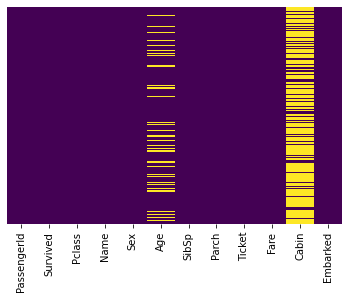

In [4]:
sns.heatmap(df_train_raw.isnull(), 
            yticklabels=False, 
            cbar=False, 
            cmap='viridis')

Age, Cabin have missing values

Let's continue on by visualizing some more of the data! 

<AxesSubplot:xlabel='Survived', ylabel='count'>

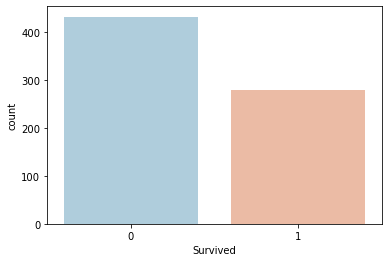

In [5]:
sns.countplot(x='Survived', data=df_train_raw, palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

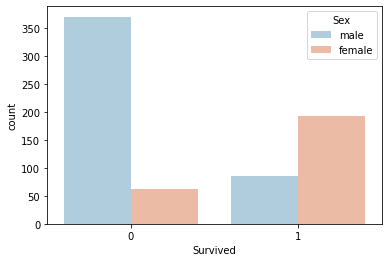

In [6]:
sns.countplot(x='Survived', 
              hue='Sex', 
              data=df_train_raw,
              palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

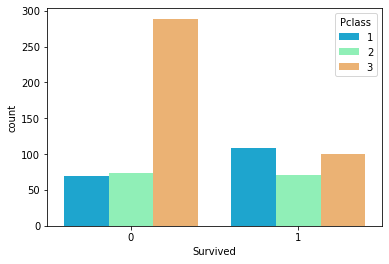

In [7]:
sns.countplot(x='Survived',
              hue='Pclass', 
              data=df_train_raw,
              palette='rainbow')

In [ ]:
sns.distplot(df_train_raw['Age'].dropna(),
             kde=True,
             color='darkred',
             bins=30)

<AxesSubplot:>

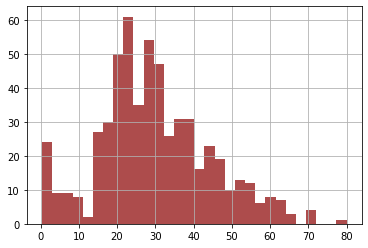

In [9]:
df_train_raw['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

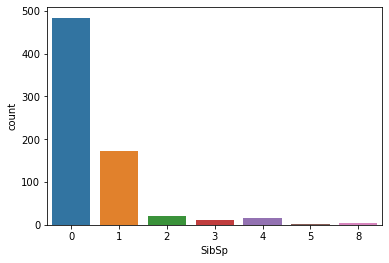

In [10]:
sns.countplot(x='SibSp',data=df_train_raw)

<AxesSubplot:>

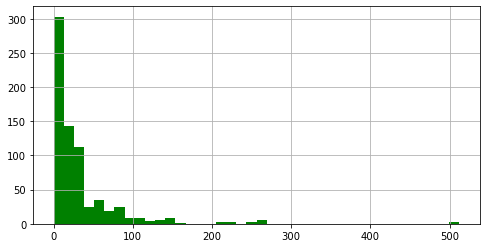

In [11]:
df_train_raw['Fare'].hist(color='green', 
                          bins=40, 
                          figsize=(8,4))

### 2.2 Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

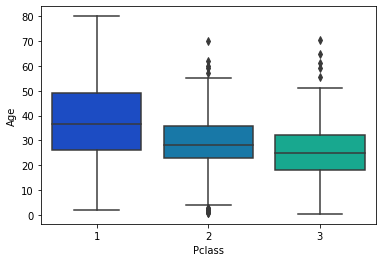

In [12]:
sns.boxplot(x='Pclass',
            y='Age',
            data=df_train_raw,
            palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [13]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now apply that function and check if it works

In [14]:
train_copy = df_train_raw.copy() # For test only
train_copy['Age'] = train_copy[['Age','Pclass']].apply(impute_age, axis=1)

Now let's check that heat map again!

<AxesSubplot:>

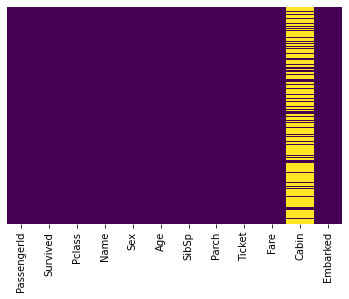

In [15]:
sns.heatmap(train_copy.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Converting Categorical Features 

We'll need to convert categorical features to one-hot encoding! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [16]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          566 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


There are 5 columns with object datatype. Among them, Name, Ticket, and Cabin are not needed. In addition, we notice Pclass is a categorical data according to the Data Dictionary we have seen above. Let’s make a function preprocessing() to keep these useful numerical features and convert the Pclass, Sex, and Embarked into one-hot encoding.

In [17]:
def preprocessing(df):

    dfresult = pd.DataFrame()
    
    # Let's keep features in the original order

    # Pclass -> one-hot encoding
    pclass = pd.get_dummies(df['Pclass'])
    pclass.columns = ['Pclass_' + str(x) for x in pclass.columns ]
    dfresult = pd.concat([dfresult, pclass],axis = 1)

    # Sex -> one-hot encoding
    sex = pd.get_dummies(df['Sex'])
    dfresult = pd.concat([dfresult,sex],axis = 1)

    # Age -> replace with imputation
    dfresult['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

    # SibSp, Parch, Fare
    dfresult['SibSp'] = df['SibSp']
    dfresult['Parch'] = df['Parch']
    dfresult['Fare'] = df['Fare']

    # Embarked -> one-hot encoding
    embarked = pd.get_dummies(df['Embarked'],dummy_na=True)
    embarked.columns = ['Embarked_' + str(x) for x in embarked.columns]
    dfresult = pd.concat([dfresult, embarked],axis = 1)

    return dfresult

In [18]:
x_train = preprocessing(df_train_raw)
y_train = df_train_raw['Survived'].values

x_test = preprocessing(df_test_raw)
y_test = df_test_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 13)
x_test.shape = (179, 13)


In [19]:
x_train.head()

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,30.5000,0,0,1,0
1,1,0,0,1,0,49.0,1,0,76.7292,1,0,0,0
2,0,1,0,1,0,36.0,0,0,13.0000,0,0,1,0
3,0,1,0,0,1,19.0,0,0,13.0000,0,0,1,0
4,0,0,1,0,1,14.0,4,1,39.6875,0,0,1,0


Our data is ready for our model!

## 3. Choose a model

Usually there are three ways of modeling using APIs of Keras. 

Here we take the simplest way: sequential modeling using function Sequential().

In [20]:
import tensorflow as tf 
from tensorflow.keras import models, layers

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(10,activation = 'relu',input_shape=(13,)))
model.add(layers.Dense(20,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


## 4. Training

Let's configure modle using `model.compile`

There are three ways for model training. Here we introduce the simplest way: using internal function fit.

In [21]:
# Convert dataframe data into np array
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# Get around with KMP duplicate issue
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Use binary cross entropy loss function for binary classification
model.compile(optimizer='sgd',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [22]:
history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2
                   )

Epoch 1/30
9/9 [==============================] - 1s 19ms/step - loss: 1.4565 - accuracy: 0.5975 - val_loss: 0.7510 - val_accuracy: 0.5874
Epoch 2/30
9/9 [==============================] - 0s 5ms/step - loss: 0.7024 - accuracy: 0.6081 - val_loss: 0.6769 - val_accuracy: 0.5944
Epoch 3/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.6151 - val_loss: 0.6607 - val_accuracy: 0.6154
Epoch 4/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.6292 - val_loss: 0.6548 - val_accuracy: 0.6014
Epoch 5/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6503 - accuracy: 0.6344 - val_loss: 0.6485 - val_accuracy: 0.6224
Epoch 6/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6432 - accuracy: 0.6538 - val_loss: 0.6439 - val_accuracy: 0.6503
Epoch 7/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.6731 - val_loss: 0.6423 - val_accuracy: 0.6713
Epoch 8/30
9/9 [=================

## 5. Model Evaluation

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

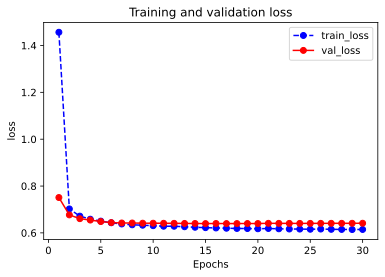

In [24]:
plot_metric(history,"loss")


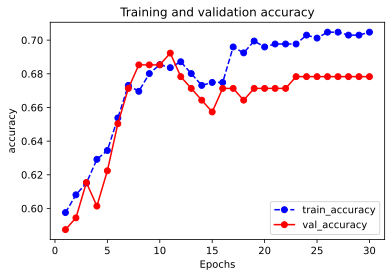

In [25]:
plot_metric(history,"accuracy")

In [26]:
# Run against test dataset

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.6648


[0.629833459854126, 0.6648044586181641]

## 6. Hyperparameter tuning

Let's use tensorboard hparams for hyperparameter tuning

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [28]:
# Clear any logs from previous runs
# t is going to mess up your dashboard if you don’t clear them.
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
# Import the TensorBoard HParams plugin:
from tensorboard.plugins.hparams import api as hp

In [30]:
'''
List the values to try, and log an experiment configuration to TensorBoard.

5, 10, and 20 for the number of units in the first layer
10, 20, and 40 for the number of units in the second layer
adam and sgd for the optimizer
'''

HP_NUM_UNITS_ONE = hp.HParam('num_units_one', hp.Discrete([5, 10, 20]))
HP_NUM_UNITS_TWO = hp.HParam('num_units_two', hp.Discrete([10, 20, 40]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_ONE, HP_NUM_UNITS_TWO, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [31]:
'''
Adopt Tensorflow runs to log hyperparameters and metrics

Model is quite simple: 3 dense layers. The code will look familiar, although the hyperparameters are no longer hardcoded. 
Instead, the hyperparameters are provided in a hyparams dictionary and used throughout the training function.
'''

def train_test_model(hparams):
  model = tf.keras.models.Sequential()
  model.add(layers.Dense(hparams[HP_NUM_UNITS_ONE], activation = 'relu',input_shape=(13,)))
  model.add(layers.Dense(hparams[HP_NUM_UNITS_TWO],activation = 'relu' ))
  model.add(layers.Dense(1,activation = 'sigmoid' ))
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(x_train, y_train, epochs=30) 
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [32]:
#For each run, log a hparams summary with the hyperparameters and final accuracy
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [33]:
'''
Start runs and log them:
We can now try multiple experiments, training each one with a different set of hypermeters. 
Let’s use a grid search that tries all combinations of the discrete parameters.
'''

session_num = 0

for num_units_one in HP_NUM_UNITS_ONE.domain.values:
  for num_units_two in HP_NUM_UNITS_TWO.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS_ONE: num_units_one,
          HP_NUM_UNITS_TWO: num_units_two,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('>> Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

>> Starting trial: run-0
{'num_units_one': 5, 'num_units_two': 10, 'optimizer': 'adam'}
Epoch 1/30
23/23 [==============================] - 0s 3ms/step - loss: 1.1638 - accuracy: 0.6587
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 0.7973 - accuracy: 0.6784
Epoch 3/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.6980
Epoch 4/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.7093
Epoch 5/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5794 - accuracy: 0.7191
Epoch 6/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7219
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5644 - accuracy: 0.7191
Epoch 8/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.7149
Epoch 9/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.7261
Epoch 10/30
23/23 [===========

23/23 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6938
Epoch 20/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6994
Epoch 21/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5985 - accuracy: 0.7079
Epoch 22/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5920 - accuracy: 0.7149
Epoch 23/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5880 - accuracy: 0.7135
Epoch 24/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.7163
Epoch 25/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5746 - accuracy: 0.7191
Epoch 26/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5689 - accuracy: 0.7219
Epoch 27/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5633 - accuracy: 0.7331
Epoch 28/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5649 - accuracy: 0.7219
Epoch 29/30
23/23 [===

23/23 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6573
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6910
Epoch 8/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6756
Epoch 9/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6798
Epoch 10/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6742
Epoch 11/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6868
Epoch 12/30
23/23 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6980
Epoch 13/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6756
Epoch 14/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6840
Epoch 15/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6966
Epoch 16/30
23/23 [======

23/23 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6812
Epoch 26/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6699
Epoch 27/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6882
Epoch 28/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6910
Epoch 29/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6770
Epoch 30/30
6/6 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6425
>> Starting trial: run-8
{'num_units_one': 10, 'num_units_two': 20, 'optimizer': 'adam'}
Epoch 1/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6966
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6055 - accuracy: 0.6938
Epoch 3/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.7065
Epoch 4/30
23/23 [===================

23/23 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.6994
Epoch 13/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5602 - accuracy: 0.7219
Epoch 14/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5602 - accuracy: 0.7219
Epoch 15/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5402 - accuracy: 0.7303
Epoch 16/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5364 - accuracy: 0.7388
Epoch 17/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5393 - accuracy: 0.7444
Epoch 18/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.7598
Epoch 19/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5233 - accuracy: 0.7598
Epoch 20/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.7837
Epoch 21/30
23/23 [==============================] - 0s 3ms/step - loss: 0.4966 - accuracy: 0.7725
Epoch 22/30
23/23 [===

6/6 [==============================] - 0s 2ms/step - loss: 0.4546 - accuracy: 0.7709
>> Starting trial: run-13
{'num_units_one': 20, 'num_units_two': 10, 'optimizer': 'sgd'}
Epoch 1/30
23/23 [==============================] - 0s 3ms/step - loss: 0.7858 - accuracy: 0.4649
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.6025
Epoch 3/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.6067
Epoch 4/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.6067
Epoch 5/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6081
Epoch 6/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.6081
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6081
Epoch 8/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6081
Epoch 9/30
23/23 [========================

23/23 [==============================] - 0s 3ms/step - loss: 0.5986 - accuracy: 0.6980
Epoch 19/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.7022
Epoch 20/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6000 - accuracy: 0.7022
Epoch 21/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5960 - accuracy: 0.6966
Epoch 22/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5973 - accuracy: 0.6910
Epoch 23/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.7051
Epoch 24/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.6910
Epoch 25/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5996 - accuracy: 0.6896
Epoch 26/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5868 - accuracy: 0.7149
Epoch 27/30
23/23 [==============================] - 0s 3ms/step - loss: 0.5917 - accuracy: 0.7022
Epoch 28/30
23/23 [===

### Visualize the results in TensorBoard’s HParams plugin
Open your terminal, and cd into your project, then run `tensorboard --logdir logs/hparam_tuning`

## 7. Prediction

In [34]:
model.predict(x_test[0:10])

array([[0.553972  ],
       [0.37399703],
       [0.5273854 ],
       [0.7239529 ],
       [0.51198244],
       [0.3830149 ],
       [0.53386855],
       [0.56097776],
       [0.5625938 ],
       [0.28091183]], dtype=float32)

In [ ]:
model.predict_classes(x_test[0:10])

### Save model

In [36]:
model.save('data/keras_model.h5')

del model  # Deleting current model

# Identical to the previous one
model = models.load_model('data/keras_model.h5')
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5876 - accuracy: 0.6592


[0.5875625610351562, 0.659217894077301]